In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import csv
import warnings
import importlib as imp
from timeit import default_timer
from scipy import stats
from scipy.interpolate import PchipInterpolator

import sys
sys.path.insert(0, "./forecaster/")
import mr_forecast as mr

import LMC
import archinfo

from oviraptor.utils import *
from oviraptor.constants import *
from oviraptor.chenkipping import *

In [2]:
#MAINPATH = 'C:/Users/djhoo/Documents/Oviraptor-master/'
MAINPATH = "/Users/research/projects/oviraptor/"
csv_file = MAINPATH + "Catalogs/oviraptor_B_manually_fixed.csv"

# number of bootstrap iterations
NBOOT = 50

# mr_relation can be 'chen-kipping', 'ning-et-al', 'neil-rogers'
MR_RELATION = "chen-kipping"

# Define System class

In [3]:
class System:
    def __init__(self, sysid=None):
        self.sysid = sysid

# Read in the data

In [4]:
# here's the planetary system data from the archive
keys, vals = read_csv_file(csv_file, k_index=0, v_index=1)

data = {}
for k in keys:
    data[k] = np.array(get_csv_data(k, keys, vals))
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("Loaded data for {0} planets in {1} systems".format(nobj, nsys))

Loaded data for 3903 planets in 2858 systems


# Convert dictionary string lists to numerical arrays

In [5]:
int_keys = ["sy_snum", "sy_pnum", "disc_year", "pl_controv_flag", "cb_flag", "ttv_flag"]


for k in data.keys():
    if np.isin(k, int_keys):
        dtype = "int"
    else:
        dtype = "float"
    
    try:
        data[k] = get_num_vals_from_str(data[k], dtype=dtype)
    except:
        pass

# Do some cleanup

### Removed mixed systems (we'll deal with them later)

In [6]:
keep = np.array(data["system_type"]) != "Mixed"

for k in data.keys():
    data[k] = data[k][keep]
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("After removing mixed systems, {0} planets in {1} systems remain".format(nobj, nsys))

After removing mixed systems, 3781 planets in 2810 systems remain


### Remove single-planet systems

In [7]:
keep = data["sy_pnum"] > 1

for k in data.keys():
    data[k] = data[k][keep]
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("After eliminating single-planet systems, {0} planets in {1} systems remain".format(nobj, nsys))

After eliminating single-planet systems, 1602 planets in 631 systems remain


### Remove long-period RV planets ($P_{\rm rv} > P_{\rm tr,\ max}$)

In [8]:
max_transit_period = data["pl_orbper"][data["system_type"] == "Transit"].max()
#max_transit_period = 500.

keep = np.array(data["pl_orbper"], dtype="float") <= max_transit_period

for k in data.keys():
    data[k] = data[k][keep]
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("After eliminating long-period planets, {0} planets in {1} systems remain".format(nobj, nsys))

After eliminating long-period planets, 1552 planets in 629 systems remain


### Remove giant planets - $m_p/M_{\oplus} > 4132$ or $r_p/R_{\oplus} > 11.1$

In [9]:
keep = (data["pl_bmasse"] < 4132)*(data["system_type"] == "Radial Velocity")
keep += (data["pl_rade"] < 11.1)*(data["system_type"] == "Transit")


for k in data.keys():
    data[k] = data[k][keep]
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("After eliminating giant planets, {0} planets in {1} systems remain".format(nobj, nsys))

After eliminating giant planets, 1536 planets in 628 systems remain


### Forecast nominal masses and radii using Chen & Kipping 2017 and remove any planets too small to have been detected by the alternate method

#### TODO: Change from mp & rp to K and rp/Rs

After eliminating tiny planets, 1469 planets in 619 systems remain


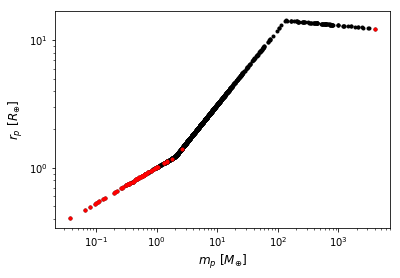

In [10]:
# set radius ratio and RV semi-amplitude cutoffs
rprs_cutoff = np.min(data["pl_ratror"][data["system_type"] == "Transit"])
kamp_cutoff = np.min(data["pl_rvamp"][data["system_type"] == "Radial Velocity"])


# determine nominal mp and rp using deterministic Chen & Kipping 2017
nominal_rad = np.copy(data["pl_rade"])
nominal_mass = np.copy(data["pl_bmasse"])

for i, planet in enumerate(data["pl_name"]):
    if data["system_type"][i] == "Transit":
        nominal_mass[i] = rad_to_mass(nominal_rad[i])
    elif data["system_type"][i] == "Radial Velocity":
        nominal_rad[i] = mass_to_rad(nominal_mass[i])

nominal_rprs = (nominal_rad/data["st_rad"])*(REARTH/RSUN)
nominal_kamp = kamp_from_mp(data["pl_orbper"], nominal_mass, data["st_mass"])

keep = (nominal_kamp > kamp_cutoff)*(data["system_type"] == "Transit")
keep += (nominal_rprs > rprs_cutoff)*(data["system_type"] == "Radial Velocity")

for k in data.keys():
    data[k] = data[k][keep]
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("After eliminating tiny planets, {0} planets in {1} systems remain".format(nobj, nsys))


plt.figure()
plt.plot(nominal_mass, nominal_rad, "k.")
plt.plot(nominal_mass[~keep], nominal_rad[~keep], "r.")
plt.xlabel(r"$m_p\ [M_{\oplus}]$", fontsize=12)
plt.ylabel(r"$r_p\ [R_{\oplus}]$", fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.show()

### Recount planets per system and remove any systems reduced to a single planet

In [11]:
keep = np.zeros(len(data["hostname"]), dtype="bool")

for i, star in enumerate(np.unique(data["hostname"])):
    use = data["hostname"] == star
    data["sy_pnum"][use] = np.sum(use)
    
    if np.sum(use) > 1:
        keep[use] = True
        
        
for k in data.keys():
    data[k] = data[k][keep]
    
nobj = len(data["pl_name"])
nsys = len(np.unique(data["hostname"]))

print("After eliminating systems reduced to a single planet, {0} planets in {1} systems remain".format(nobj, nsys))

After eliminating systems reduced to a single planet, 1407 planets in 557 systems remain


### Print out some statistics on planet counts

In [12]:
RV = data["system_type"] == "Radial Velocity"
TR = data["system_type"] == "Transit"
npl = np.array(data["sy_pnum"], dtype="int")

# Radial Velocity systems
print("\nRADIAL VELOCITY")

nobj, nsys = len(data["pl_name"][RV]), len(np.unique(data["hostname"][RV]))
print(" {0} planets in {1} systems".format(nobj, nsys))

nobj, nsys = len(data["pl_name"][RV*(npl >= 3)]), len(np.unique(data["hostname"][RV*(npl >= 3)]))
print(" {0} planets in {1} high multiplicity (N >= 3) systems".format(nobj, nsys))

print()
print(np.unique(data["hostname"][RV*(npl >= 3)]))


# Transit systems
print("\n\nTRANSIT")

nobj, nsys = len(data["pl_name"][TR]), len(np.unique(data["hostname"][TR]))
print(" {0} planets in {1} systems".format(nobj, nsys))

nobj, nsys = len(data["pl_name"][TR*(npl >= 3)]), len(np.unique(data["hostname"][TR*(npl >= 3)]))
print(" {0} planets in {1} high multiplicity (N >= 3) systems".format(nobj, nsys))

print("\n Of the high multiplicity systems...")

KEP = data["disc_facility"] == "Kepler"
K2 = data["disc_facility"] == "K2"
TESS = data["disc_facility"] == "Transiting Exoplanet Survey Satellite (TESS)"

nobj, nsys = len(data["pl_name"][KEP*(npl>2)]), len(np.unique(data["hostname"][KEP*(npl>2)]))
print("  {0} planets in {1} systems discovered by Kepler".format(nobj, nsys))

nobj, nsys = len(data["pl_name"][K2*(npl>2)]), len(np.unique(data["hostname"][K2*(npl>2)]))
print("  {0} planets in {1} systems discovered by K2".format(nobj, nsys))

nobj, nsys = len(data["pl_name"][TESS*(npl>2)]), len(np.unique(data["hostname"][TESS*(npl>2)]))
print("  {0} planets in {1} systems discovered by TESS".format(nobj, nsys))


RADIAL VELOCITY
 192 planets in 73 systems
 106 planets in 30 high multiplicity (N >= 3) systems

['55 Cnc' '61 Vir' 'DMPP-1' 'GJ 1061' 'GJ 163' 'GJ 180' 'GJ 3138'
 'GJ 3293' 'GJ 581' 'GJ 676 A' 'GJ 876' 'HD 10180' 'HD 136352' 'HD 141399'
 'HD 158259' 'HD 160691' 'HD 20781' 'HD 20794' 'HD 215152' 'HD 219134'
 'HD 31527' 'HD 34445' 'HD 40307' 'HD 69830' 'HD 7924' 'HIP 14810'
 'HIP 57274' 'Wolf 1061' 'YZ Cet' 'tau Cet']


TRANSIT
 1215 planets in 484 systems
 585 planets in 169 high multiplicity (N >= 3) systems

 Of the high multiplicity systems...
  457 planets in 133 systems discovered by Kepler
  89 planets in 26 systems discovered by K2
  30 planets in 9 systems discovered by TESS


# Build lists of systems

In [13]:
multis = []
doubles = []

for i, star in enumerate(np.unique(data["hostname"])):
    use = (data["hostname"] == star)
    
    s = System(sysid=star)
    
    s.mstar = float(data["st_mass"][use][0])
    s.mstar_err = np.sqrt(data["st_masserr1"][use][0]**2 + data["st_masserr2"][use][0]**2)/np.sqrt(2)

    s.rstar = float(data["st_rad"][use][0])
    s.rstar_err = np.sqrt(data["st_raderr1"][use][0]**2 + data["st_raderr2"][use][0]**2)/np.sqrt(2)

    s.npl = np.sum(use)
    s.per = data["pl_orbper"][use]
    
    order = np.argsort(s.per)
    s.per = s.per[order]
    
    
    if data["system_type"][use][0] == "Radial Velocity":
        s.discoverymethod = "RV"
        
        s.kamp = data["pl_rvamp"][use][order]
        s.kamp_err = np.sqrt(data["pl_rvamperr1"][use]**2 + data["pl_rvamperr2"][use]**2)[order]/np.sqrt(2)
        
        s.ecc = data["pl_orbeccen"][use][order]
        s.ecc_err = np.sqrt(data["pl_orbeccenerr1"][use]**2 + data["pl_orbeccenerr2"][use]**2)[order]/np.sqrt(2)
        
        bad = np.isnan(s.ecc) + np.isnan(s.ecc_err)
        s.ecc[bad] = 0.0
        s.ecc_err[bad] = 0.0
        
        
    if data["system_type"][use][0] == "Transit":
        s.discoverymethod = "Transit"
        
        s.rprs = data["pl_ratror"][use][order]
        s.rprs_err = np.sqrt(data["pl_ratrorerr1"][use]**2 + data["pl_ratrorerr2"][use]**2)[order]/np.sqrt(2)
        
        
    if s.npl == 2:
        doubles.append(s)
    elif s.npl > 2:
        multis.append(s)

# Select which systems to use -- TODO: put switch at top of code

In [14]:
systems = multis

# Draw probabilistic masses and radii

In [15]:
RV = data["discoverymethod"] == "Radial Velocity"
TR = data["discoverymethod"] == "Transit"

loc = np.argmin(data["pl_bmasse"][RV])
min_accept_mass = data["pl_bmasse"][RV][loc] + 3*data["pl_bmasseerr2"][RV][loc]

loc = np.argmax(data["pl_bmasse"][RV])
max_accept_mass = data["pl_bmasse"][RV][loc] + 3*data["pl_bmasseerr1"][RV][loc]
max_accept_mass = np.min([max_accept_mass, 4132])

loc = np.argmin(data["pl_rade"][TR])
min_accept_rad = data["pl_rade"][TR][loc] + 3*data["pl_radeerr2"][TR][loc]

loc = np.argmax(data["pl_rade"][TR])
max_accept_rad = data["pl_rade"][TR][loc] + 3*data["pl_radeerr1"][TR][loc]

In [16]:
for i, s in enumerate(systems):
    
    # RADIAL VELOCITY
    if (s.discoverymethod == "RV"):
        print(s.sysid)
        
        s.prob_mstar = stats.truncnorm((0.07-s.mstar)/s.mstar_err, np.inf, 
                                       loc=s.mstar, scale=s.mstar_err).rvs(NBOOT)
        
        s.prob_rstar = stats.truncnorm((0.09-s.rstar)/s.rstar_err, np.inf, 
                                       loc=s.rstar, scale=s.rstar_err).rvs(NBOOT)

        s.prob_kamp = np.zeros((NBOOT,s.npl))
        s.prob_mp = np.zeros((NBOOT,s.npl))
        s.prob_rp = np.zeros((NBOOT,s.npl))
        
        
        for j in range(s.npl):
            
            draw = np.ones(NBOOT, dtype="bool")
            count = 0
            
            while (np.sum(draw) > 0)*(count < 10):
                count +=1
                
                s.prob_kamp[:,j][draw] = stats.truncnorm((kamp_cutoff-s.kamp[j])/s.kamp_err[j], np.inf, 
                                                          loc=s.kamp[j], scale=s.kamp_err[j]).rvs(np.sum(draw))
            
                for n in range(NBOOT):
                    if draw[n]:
                        s.prob_mp[n,j] = mp_from_kamp(s.prob_kamp[n,j], s.per[j], s.prob_mstar[n], s.ecc[j])
                        
                
                if MR_RELATION == "chen-kipping":
                    s.prob_rp[:,j][draw] = mr.Mpost2R(s.prob_mp[:,j][draw])    
                
                
                draw = s.prob_rp[:,j] == None
                draw += (s.prob_rp[:,j] < min_accept_rad) + (s.prob_rp[:,j] > max_accept_rad)
                draw += (s.prob_mp[:,j] < min_accept_mass) + (s.prob_mp[:,j] > max_accept_mass)
                
                
            if np.sum(draw) > 0:
                print("{0} draws failed to converge".format(np.sum(draw)))
                s.prob_mp[:,j][draw] = np.random.choice(s.prob_mp[:,j][~draw], size=np.sum(draw))
                s.prob_mp[:,j][draw] += np.random.normal(size=np.sum(draw))*0.01
                
                s.prob_rp[:,j][draw] = np.random.choice(s.prob_rp[:,j][~draw], size=np.sum(draw))
                s.prob_rp[:,j][draw] += np.random.normal(size=np.sum(draw))*0.01

55 Cnc
5 draws failed to converge
61 Vir
DMPP-1
GJ 1061
GJ 163
GJ 180
GJ 3138
GJ 3293
GJ 581
GJ 676 A
1 draws failed to converge
GJ 876
5 draws failed to converge
2 draws failed to converge
HD 10180
HD 136352
HD 141399
4 draws failed to converge
4 draws failed to converge
1 draws failed to converge
HD 158259
HD 160691
7 draws failed to converge
4 draws failed to converge
HD 20781
HD 20794
HD 215152
HD 219134
HD 31527
HD 34445
5 draws failed to converge
HD 40307
HD 69830
HD 7924
HIP 14810
1 draws failed to converge
9 draws failed to converge
HIP 57274
1 draws failed to converge
10 draws failed to converge
Wolf 1061
YZ Cet
tau Cet


In [17]:
for i, s in enumerate(systems):
    
    # TRANSIT
    if (s.discoverymethod == "Transit"):
        print(s.sysid)
        
        s.prob_mstar = stats.truncnorm((0.07-s.mstar)/s.mstar_err, np.inf, 
                                       loc=s.mstar, scale=s.mstar_err).rvs(NBOOT)
        
        s.prob_rstar = stats.truncnorm((0.09-s.rstar)/s.rstar_err, np.inf, 
                                       loc=s.rstar, scale=s.rstar_err).rvs(NBOOT)

        s.prob_rprs = np.empty((NBOOT,s.npl))
        s.prob_rp = np.empty((NBOOT,s.npl))
        s.prob_mp = np.empty((NBOOT,s.npl))
        
        
        for j in range(s.npl):
            
            draw = np.ones(NBOOT, dtype="bool")
            count = 0
            
            while (np.sum(draw) > 0)*(count < 10):
                count +=1
                
                s.prob_rprs[:,j][draw] = stats.truncnorm((rprs_cutoff-s.rprs[j])/s.rprs_err[j], np.inf, 
                                                          loc=s.rprs[j], scale=s.rprs_err[j]).rvs(np.sum(draw))
            
                s.prob_rp[:,j][draw] = s.prob_rprs[:,j][draw]*s.prob_rstar[draw]*RSUN/REARTH
                
                
                if MR_RELATION == "chen-kipping":
                    s.prob_mp[:,j][draw] = mr.Rpost2M(s.prob_rp[:,j][draw])    
                
                
                draw = s.prob_mp[:,j] == None
                draw += (s.prob_mp[:,j] < min_accept_mass) + (s.prob_mp[:,j] > max_accept_mass)
                draw += (s.prob_rp[:,j] < min_accept_rad) + (s.prob_rp[:,j] > max_accept_rad)
                
                
            if np.sum(draw) > 0:
                print("{0} draws failed to converge".format(np.sum(draw)))
                s.prob_rp[:,j][draw] = np.random.choice(s.prob_rp[:,j][~draw], size=np.sum(draw))
                s.prob_rp[:,j][draw] += np.random.normal(size=np.sum(draw))*0.01
                
                s.prob_mp[:,j][draw] = np.random.choice(s.prob_mp[:,j][~draw], size=np.sum(draw))
                s.prob_mp[:,j][draw] += np.random.normal(size=np.sum(draw))*0.01

EPIC 249893012
GJ 9827
HD 108236
HD 191939
HIP 41378
HR 858
K2-133
K2-136
K2-138
K2-148
K2-155
K2-16
K2-165
K2-183
K2-187
K2-19
K2-198
K2-219
K2-233
K2-239
K2-266
K2-285
K2-3
K2-32
K2-37
K2-58
K2-72
K2-80
KOI-351
KOI-94
Kepler-100
Kepler-104
Kepler-107
Kepler-11
Kepler-114
Kepler-1254
Kepler-126
Kepler-127
Kepler-132
Kepler-1388
Kepler-142
Kepler-148
5 draws failed to converge
Kepler-149
Kepler-150
Kepler-154
Kepler-157
Kepler-164
Kepler-166
Kepler-167
Kepler-169
Kepler-171
1 draws failed to converge
1 draws failed to converge
Kepler-172
Kepler-174
Kepler-176
Kepler-178
3 draws failed to converge
3 draws failed to converge
3 draws failed to converge
Kepler-18
Kepler-184
2 draws failed to converge
2 draws failed to converge
1 draws failed to converge
Kepler-186
Kepler-191
1 draws failed to converge
5 draws failed to converge
Kepler-192
Kepler-194
2 draws failed to converge
1 draws failed to converge
Kepler-197
Kepler-198
Kepler-203
Kepler-206
1 draws failed to converge
Kepler-207
Kepler

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


V1298 Tau


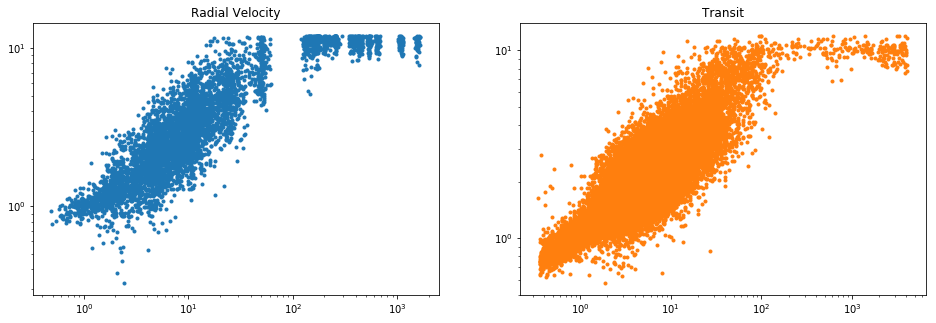

In [18]:
prob_mass_rv = []
prob_rad_rv  = []
prob_mass_tr = []
prob_rad_tr  = []

for i, s in enumerate(systems):
    if s.discoverymethod == "RV":
        prob_mass_rv.append(s.prob_mp.reshape(-1))
        prob_rad_rv.append(s.prob_rp.reshape(-1))
        
    if s.discoverymethod == "Transit":
        prob_mass_tr.append(s.prob_mp.reshape(-1))
        prob_rad_tr.append(s.prob_rp.reshape(-1))
        

fig, ax = plt.subplots(1,2, figsize=(16,5))

ax[0].plot(np.hstack(prob_mass_rv), np.hstack(prob_rad_rv), ".", c="C0")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_title("Radial Velocity")

ax[1].plot(np.hstack(prob_mass_tr), np.hstack(prob_rad_tr), ".", c="C1")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_title("Transit")

plt.show()

# Calculate archinfo statistics

In [19]:
for i, s in enumerate(systems):
    print(s.sysid)

    s.prob_mu = np.zeros(NBOOT)
    s.prob_Q = np.zeros(NBOOT)
    s.prob_M = np.zeros(NBOOT)
    s.prob_S = np.zeros(NBOOT)
    s.prob_C = np.zeros(NBOOT)

    for nboot in range(NBOOT):
        s.prob_mu[nboot] = archinfo.mu(s.prob_mp[nboot], s.prob_mstar[nboot])
        s.prob_Q[nboot] = archinfo.Q(s.prob_mp[nboot])
        s.prob_M[nboot] = archinfo.M(s.per, s.prob_mp[nboot])
        s.prob_S[nboot] = archinfo.S(s.per, s.prob_mp[nboot], s.prob_mstar[nboot])
        s.prob_C[nboot] = archinfo.C(s.per)

55 Cnc
61 Vir
DMPP-1
EPIC 249893012
GJ 1061
GJ 163
GJ 180
GJ 3138
GJ 3293
GJ 581
GJ 676 A
GJ 876
GJ 9827
HD 10180
HD 108236
HD 136352
HD 141399
HD 158259
HD 160691
HD 191939
HD 20781
HD 20794
HD 215152
HD 219134
HD 31527
HD 34445
HD 40307
HD 69830
HD 7924
HIP 14810
HIP 41378
HIP 57274
HR 858
K2-133
K2-136
K2-138
K2-148
K2-155
K2-16
K2-165
K2-183
K2-187
K2-19
K2-198
K2-219
K2-233
K2-239
K2-266
K2-285
K2-3
K2-32
K2-37
K2-58
K2-72
K2-80
KOI-351
KOI-94
Kepler-100
Kepler-104
Kepler-107
Kepler-11
Kepler-114
Kepler-1254
Kepler-126
Kepler-127
Kepler-132
Kepler-1388
Kepler-142
Kepler-148
Kepler-149
Kepler-150
Kepler-154
Kepler-157
Kepler-164
Kepler-166
Kepler-167
Kepler-169
Kepler-171
Kepler-172
Kepler-174
Kepler-176
Kepler-178
Kepler-18
Kepler-184
Kepler-186
Kepler-191
Kepler-192
Kepler-194
Kepler-197
Kepler-198
Kepler-203
Kepler-206
Kepler-207
Kepler-208
Kepler-215
Kepler-217
Kepler-218
Kepler-219
Kepler-221
Kepler-222
Kepler-223
Kepler-224
Kepler-226
Kepler-228
Kepler-229
Kepler-23
Kepler-23

/Users/research/projects/oviraptor/LMC.py:49: UserWarning: Input probability vector was not normalized...fixing automatically
  warnings.warn('Input probability vector was not normalized...fixing automatically')



Kepler-372
Kepler-374
Kepler-385
Kepler-401
Kepler-402
Kepler-403
Kepler-445
Kepler-446
Kepler-49
Kepler-51
Kepler-52
Kepler-53
Kepler-54
Kepler-55
Kepler-58
Kepler-60
Kepler-603
Kepler-62
Kepler-758
Kepler-770
Kepler-79
Kepler-80
Kepler-81
Kepler-83
Kepler-84
Kepler-85
Kepler-9
Kepler-92
L 98-59
TOI-125
TOI-178
TOI-270
TOI-451
TOI-700
TRAPPIST-1
V1298 Tau
Wolf 1061
YZ Cet
tau Cet


# Assign weights to transiting systems based on stellar masses

In [20]:
hosts = dict.fromkeys(["sysid", "npl", "mstar", "mstar_err", "rstar", "rstar_err", "discoverymethod", "weight"])

for k in hosts.keys():
    hosts[k] = []

for i, s in enumerate(systems):
    hosts["npl"].append(s.npl)
    hosts["sysid"].append(s.sysid)
    hosts["mstar"].append(s.mstar)
    hosts["rstar"].append(s.rstar)
    hosts["mstar_err"].append(s.mstar_err)
    hosts["rstar_err"].append(s.rstar_err)
    hosts["discoverymethod"].append(s.discoverymethod)
    hosts["weight"].append(np.nan)
        
for k in hosts.keys():
    hosts[k] = np.asarray(hosts[k])

In [21]:
RV = hosts["discoverymethod"] == "RV"
TR = hosts["discoverymethod"] == "Transit"

hosts["mstar"][RV].min(), hosts["mstar"][RV].max()

(0.12, 1.21)

In [22]:
# pull all probabilistic masses for RV stars
mrv = []

for i, s in enumerate(systems):
    if s.discoverymethod == "RV":
        mrv.append(s.prob_mstar)
        
mrv = np.hstack(mrv)

mrv.min(), mrv.max()

(0.09766139181864501, 1.2837695362322536)

In [23]:
# fraction of stellar masses (any detection method) beyond RV limit
f_low = np.sum(hosts["mstar"] < mrv.min())/len(hosts["mstar"])
f_high = np.sum(hosts["mstar"] > mrv.max())/len(hosts["mstar"])

f_low, f_high

(0.005025125628140704, 0.035175879396984924)

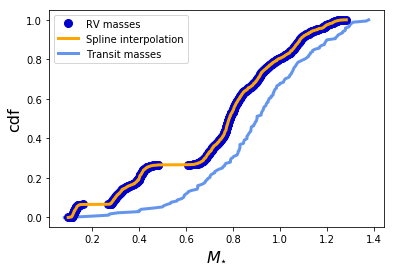

In [24]:
# generate a monotonic cubic spline (added noise prevents duplicate values)
train_x = np.sort(mrv + np.random.normal(loc=0, scale=100*sys.float_info.epsilon, size=len(mrv)))
train_y = np.linspace(0, 1, len(mrv))

spline = PchipInterpolator(train_x, train_y, extrapolate=False)

fit_x = np.linspace(train_x.min(), train_x.max(), len(train_x))
fit_y = spline(fit_x)


# now determine weights for transit host stars
wtr = spline(hosts["mstar"][TR])
wtr /= np.nanmax(wtr)

hosts["weight"][TR] = wtr


# plot the results
plt.figure()
plt.plot(train_x, train_y, "o", ms=8, c="mediumblue", label="RV masses")
plt.plot(fit_x, fit_y, c="orange", lw=3, label="Spline interpolation")
plt.plot(np.sort(hosts["mstar"][TR]), np.linspace(0,1,np.sum(TR)), 
         c="cornflowerblue", lw=3, label="Transit masses", zorder=0)
plt.xlabel(r"$M_{\star}$", fontsize=16)
plt.ylabel("cdf", fontsize=16)
plt.legend()
plt.show()

# Now it's time to actually draw sub-samples

In [25]:
RV = hosts["discoverymethod"] == "RV"
TR = hosts["discoverymethod"] == "Transit"

NSYS = np.sum(RV)

# set up dictionaries to hold bootstrap draws
ai_keys = ["N", "mu", "logmu", "Q", "M", "S", "C"]
pl_keys = ["mp", "rp", "per", "mrat", "rrat", "prat"]

subpops_rv = dict.fromkeys(ai_keys)
subpops_tr = dict.fromkeys(ai_keys)
KS = dict.fromkeys(ai_keys)
AD = dict.fromkeys(ai_keys)

for k in ai_keys:
    subpops_rv[k] = np.zeros((NBOOT,NSYS))
    subpops_tr[k] = np.zeros((NBOOT,NSYS))
    KS[k] = np.zeros(NBOOT)
    AD[k] = np.zeros(NBOOT)
    
    
for k in pl_keys:
    subpops_rv[k] = [None]*NBOOT
    subpops_tr[k] = [None]*NBOOT
    
    for i in range(NBOOT):
        subpops_rv[k][i] = []
        subpops_tr[k][i] = []
    
    KS[k] = np.zeros(NBOOT)
    AD[k] = np.zeros(NBOOT)
    

# RADIAL VELOCITY systems
RV = hosts["discoverymethod"] == "RV"

for i in range(NBOOT):
    boot_index = np.random.randint(0,NBOOT,size=NSYS)
    

    # make a single draw for each RV system
    for j in range(NSYS):
        
        # draw random systems w/ replacement
        s = systems[np.where(hosts["sysid"] == np.random.choice(hosts["sysid"][RV]))[0][0]]
        
        subpops_rv["N"][i,j]  = s.npl
        subpops_rv["mu"][i,j] = s.prob_mu[boot_index[j]]
        subpops_rv["Q"][i,j]  = s.prob_Q[boot_index[j]]
        subpops_rv["M"][i,j]  = s.prob_M[boot_index[j]]
        subpops_rv["S"][i,j]  = s.prob_S[boot_index[j]]
        subpops_rv["C"][i,j]  = s.prob_C[boot_index[j]]
        
        subpops_rv["mp"][i].append(s.prob_mp[boot_index[j]])
        subpops_rv["rp"][i].append(s.prob_rp[boot_index[j]])
        subpops_rv["per"][i].append(s.per)
        
        subpops_rv["mrat"][i].append(s.prob_mp[boot_index[j]][1:]/s.prob_mp[boot_index[j]][:-1])
        subpops_rv["rrat"][i].append(s.prob_rp[boot_index[j]][1:]/s.prob_rp[boot_index[j]][:-1])
        subpops_rv["prat"][i].append(s.per[1:]/s.per[:-1])
        
    # sort the data for this bootstrap iteration
    for k in ai_keys:
        subpops_rv[k][i] = np.sort(subpops_rv[k][i])
        
    for k in pl_keys:
        subpops_rv[k][i] = np.sort(np.hstack(subpops_rv[k][i]))
        
        
# TRANSIT systems
TR = hosts["discoverymethod"] == "Transit"

for i in range(NBOOT):
    boot_index = np.random.randint(0,NBOOT,size=NSYS)
        
    # make weighted random draws w/o replacement
    for j in range(NSYS):
        
        w_rand = np.random.uniform(0,1)
        w_delta = hosts["weight"] - w_rand
        w_delta[w_delta < 0] = np.inf
        w_delta[np.isnan(loc)] = np.inf
        
        s = systems[np.nanargmin(w_delta)]
        
        subpops_tr["N"][i,j]  = s.npl
        subpops_tr["mu"][i,j] = s.prob_mu[boot_index[j]]
        subpops_tr["Q"][i,j]  = s.prob_Q[boot_index[j]]
        subpops_tr["M"][i,j]  = s.prob_M[boot_index[j]]
        subpops_tr["S"][i,j]  = s.prob_S[boot_index[j]]
        subpops_tr["C"][i,j]  = s.prob_C[boot_index[j]]
        
        subpops_tr["mp"][i].append(s.prob_mp[boot_index[j]])
        subpops_tr["rp"][i].append(s.prob_rp[boot_index[j]])
        subpops_tr["per"][i].append(s.per)
    
        subpops_tr["mrat"][i].append(s.prob_mp[boot_index[j]][1:]/s.prob_mp[boot_index[j]][:-1])
        subpops_tr["rrat"][i].append(s.prob_rp[boot_index[j]][1:]/s.prob_rp[boot_index[j]][:-1])
        subpops_tr["prat"][i].append(s.per[1:]/s.per[:-1])
        
        
    # sort the data for this bootstrap iteration
    for k in ai_keys:
        subpops_tr[k][i] = np.sort(subpops_tr[k][i])

    for k in pl_keys:
        subpops_tr[k][i] = np.sort(np.hstack(subpops_tr[k][i]))
        
        
# calculate logmu
subpops_rv["logmu"] = np.log10(subpops_rv["mu"])
subpops_tr["logmu"] = np.log10(subpops_tr["mu"])

In [26]:
# on rare occasions something will go wrong and complexity measures will return NaN
# quietly fix this, but you should check to make sure this doesn't happen often

for i, k in enumerate(ai_keys):
    
    bad = np.isnan(subpops_rv[k])
    if np.sum(bad) > 0:
        subpops_rv[k][bad] = np.nanmedian(subpops_rv[k])
        warnings.warn("Fixing {0} NaN values in RV-{1}".format(np.sum(bad),k))
        
    bad = np.isnan(subpops_tr[k]) 
    if np.sum(bad) > 0:
        subpops_tr[k][bad] = np.nanmedian(subpops_tr[k])
        warnings.warn("Fixing {0} NaN values in Transit-{1}".format(np.sum(bad),k))        

In [27]:
# calculate the test statistics
for i in range(NBOOT):
    for k in ai_keys:
        KS[k][i] = stats.ks_2samp(subpops_rv[k][i], subpops_tr[k][i])[1]
        AD[k][i] = extrapolated_anderson_2samp(subpops_rv[k][i], subpops_tr[k][i])[1]
        
        
    for k in pl_keys:
        KS[k][i] = stats.ks_2samp(subpops_rv[k][i], subpops_tr[k][i])[1]
        AD[k][i] = extrapolated_anderson_2samp(subpops_rv[k][i], subpops_tr[k][i])[1]

/Users/research/projects/oviraptor/oviraptor/utils.py:148: UserWarning: p-value capped: true value larger than 0.25
  A, cv, p = stats.anderson_ksamp([x1, x2])
/Users/research/projects/oviraptor/oviraptor/utils.py:148: UserWarning: p-value floored: true value smaller than 0.001
  A, cv, p = stats.anderson_ksamp([x1, x2])


# Here's a plotting function

In [28]:
def plot_cdf(x_tr, x_rv, ks, ad, name=None, gridsize=1000, colors=("k", "r"), labels=("Transit", "RV")):

    x_min = np.min([np.min(np.hstack(x_tr)), np.min(np.hstack(x_rv))])
    x_max = np.min([np.max(np.hstack(x_tr)), np.max(np.hstack(x_rv))])

    X = np.linspace(x_min, x_max, gridsize)
    Y_tr = np.zeros((len(x_tr), gridsize))
    Y_rv = np.zeros_like(Y_tr)

    for i in range(Y_tr.shape[0]):
        for j in range(Y_tr.shape[1]):
            Y_tr[i,j] = np.sum(x_tr[i] <= X[j])/len(x_tr[i])
            Y_rv[i,j] = np.sum(x_rv[i] <= X[j])/len(x_rv[i])


    Y = (Y_tr, Y_rv)

    fig, ax = plt.subplots(1,2, figsize=(16,5))        

    for i, Y_ in enumerate(Y):
        # calculate mean and 1-sigma contours
        Y_mu = Y_.mean(0)
        Y_sd = Y_.std(0)
        Y_dn = np.maximum(np.zeros_like(Y_mu),Y_mu-Y_sd)
        Y_up = np.minimum(np.ones_like(Y_mu),Y_mu+Y_sd)

        # enforce monotonicity on contours
        for j in range(1,gridsize):
            if Y_up[j] < Y_up[j-1]:
                Y_up[j] = Y_up[j-1]

        for j in range(1,gridsize):
            if Y_dn[gridsize-j-1] > Y_dn[gridsize-j]:
                Y_dn[gridsize-j-1] = Y_dn[gridsize-j]

        ax[0].plot(X, Y_mu, c=colors[i], label=labels[i])
        ax[0].fill_between(X, Y_up, Y_dn, color=colors[i], alpha=0.2)
        ax[0].legend(fontsize=16)
        ax[0].set_xlabel(name, fontsize=20)
        ax[0].set_ylabel("cdf", fontsize=20)
    
    # set bin sizes automatically
    binmin = np.floor(np.min([np.log10(ks), np.log10(ad)]))
    bins = np.linspace(binmin, 0, int(2*np.abs(binmin))+1)
    
    # get median KS and AD values (offset slightly for plotting purposes if needed)
    ks_med = np.log10(np.median(ks))
    ad_med = np.log10(np.median(ad))
    
    if np.abs(ks_med-ad_med) < 0.1:
        ks_med += 0.05 * np.sign(ks_med-ad_med)
        ad_med -= 0.05 * np.sign(ks_med-ad_med)
    
    ax[1].hist(np.log10(ks), bins=bins, color="cornflowerblue", histtype="step", lw=3, label="Kolmogorov-Smirnov")
    ax[1].hist(np.log10(ad), bins=bins, color="orange", histtype="step", lw=3, label="Anderson-Darling")
    ax[1].axvline(ks_med, color="navy", lw=3, ls="--")
    ax[1].axvline(ad_med, color="red", lw=3, ls="-.")
    ax[1].set_xlabel("$\log(p_{KS|AD})$", fontsize=20)
    ax[1].set_yticks([])
    ax[1].legend(fontsize=16)
        
    return fig, ax

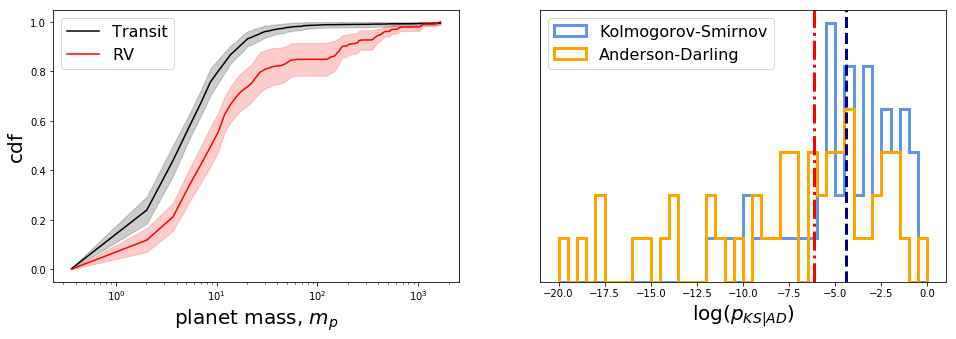

In [29]:
k = "mp"
name = "planet mass, $m_p$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)
ax[0].set_xscale("log")

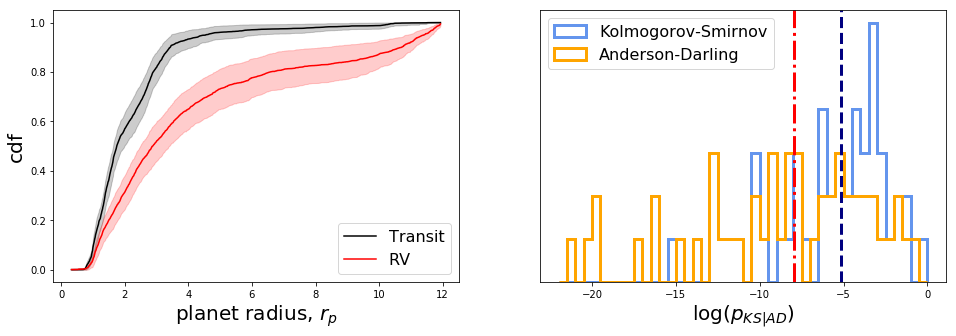

In [30]:
k = "rp"
name = "planet radius, $r_p$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

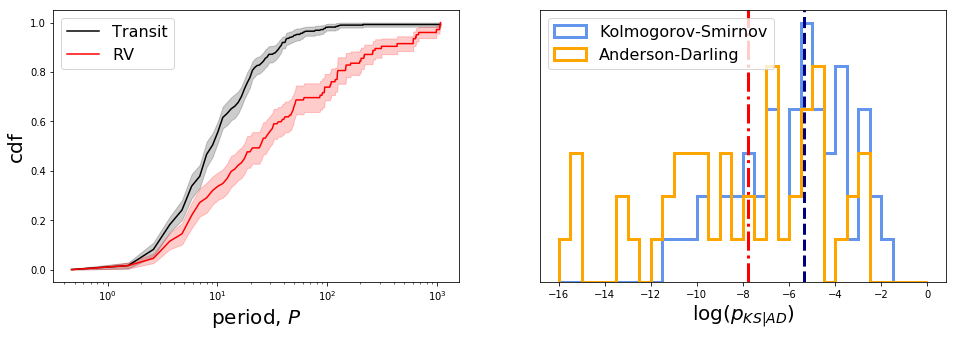

In [40]:
k = "per"
name = "period, $P$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)
ax[0].set_xscale("log")

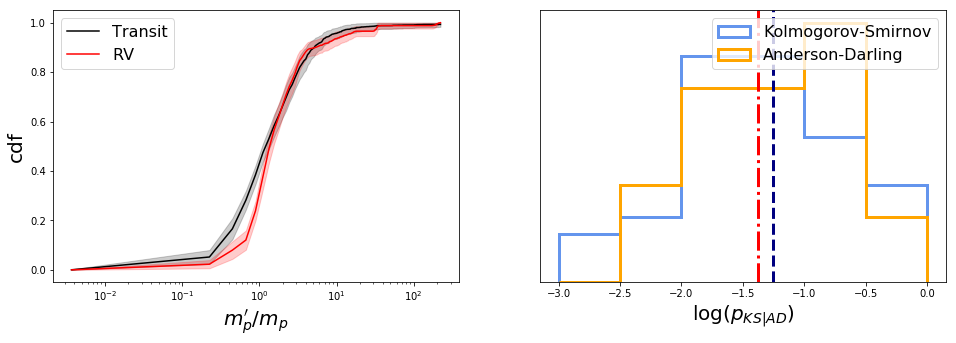

In [32]:
k = "mrat"
name = "$m_p'/m_p$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)
ax[0].set_xscale("log")

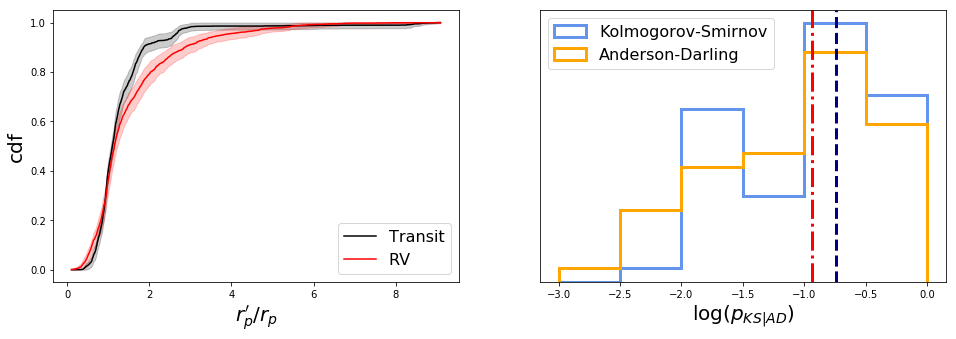

In [33]:
k = "rrat"
name = "$r_p'/r_p$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

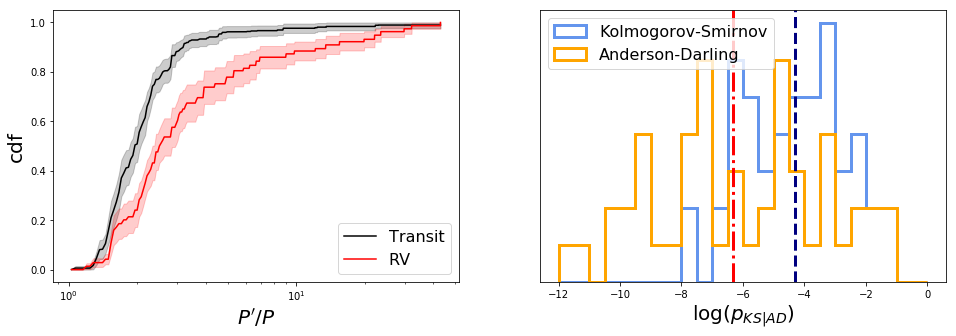

In [34]:
k = "prat"
name = "$P'/P$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)
ax[0].set_xscale("log")

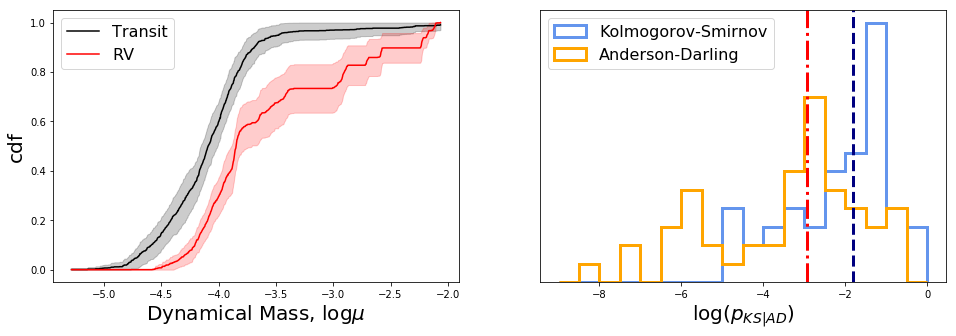

In [35]:
k = "logmu"
name = "Dynamical Mass, $\log\mu$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

fig.savefig(MAINPATH + "Figures/cdf_mu_dynamical_mass.pdf", bbox_inches="tight")

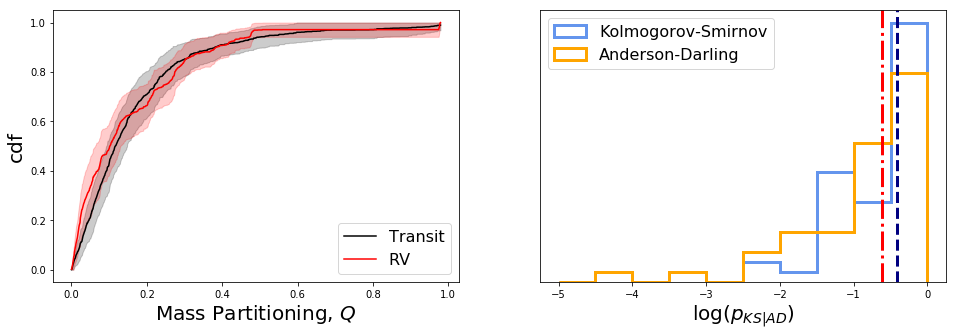

In [36]:
k = "Q"
name = "Mass Partitioning, $Q$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

fig.savefig(MAINPATH + "Figures/cdf_Q_mass_partitioning.pdf", bbox_inches="tight")

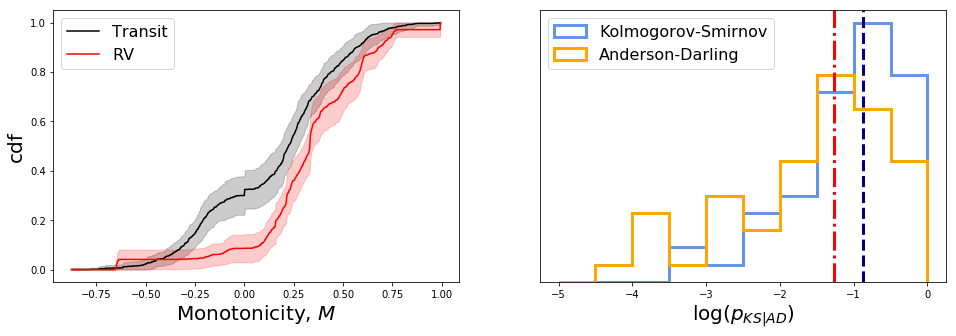

In [37]:
k = "M"
name = "Monotonicity, $M$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

fig.savefig(MAINPATH + "Figures/cdf_M_monotonicity.pdf", bbox_inches="tight")

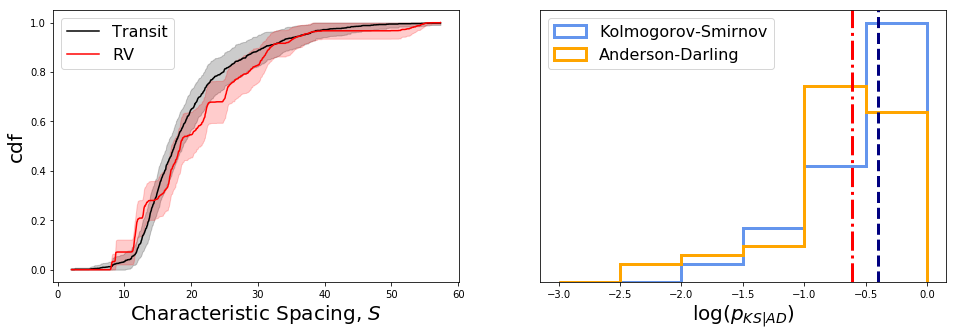

In [38]:
k = "S"
name = "Characteristic Spacing, $S$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

fig.savefig(MAINPATH + "Figures/cdf_S_characteristic_spacing.pdf", bbox_inches="tight")

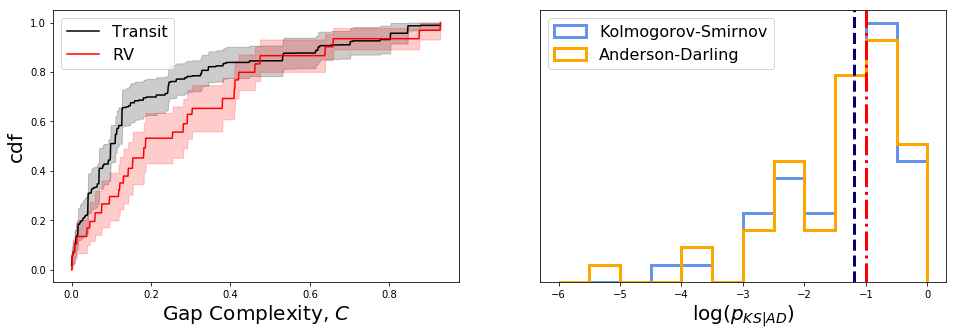

In [39]:
k = "C"
name = "Gap Complexity, $C$"

fig, ax = plot_cdf(subpops_tr[k], subpops_rv[k], KS[k], AD[k], name=name)

fig.savefig(MAINPATH + "Figures/cdf_C_gap_complexity.pdf", bbox_inches="tight")